<a href="https://colab.research.google.com/github/bagusamandira/Neural-Network/blob/main/GAN-mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
!pip install --upgrade torch torchvision

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import numpy as np
from matplotlib.patches import Rectangle
import pylab as plt

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

#Data preprocessing

In [5]:
class BlockMaskedMNIST(Dataset):
    def __init__(self, block_len, data_dir='src/mnist-data', random_seed=0):
        self.block_len = block_len
        self.rnd = np.random.RandomState(random_seed)
        data = datasets.MNIST(data_dir, train=True, download=True,
                              transform=transforms.ToTensor())
        self.data_size = len(data)
        self.generate_incomplete_data(data)

    def __getitem__(self, index):
        # return index so we can retrieve the mask location from self.mask_loc
        return self.image[index], self.mask[index], index

    def __len__(self):
        return self.data_size

    def generate_incomplete_data(self, data):
        n_masks = self.data_size
        self.image = [None] * n_masks
        self.mask = [None] * n_masks
        self.mask_loc = [None] * n_masks
        for i in range(n_masks):
            d0 = self.rnd.randint(0, 28 - self.block_len + 1)
            d1 = self.rnd.randint(0, 28 - self.block_len + 1)
            mask = torch.zeros((28, 28), dtype=torch.uint8)
            mask[d0:(d0 + self.block_len), d1:(d1 + self.block_len)] = 1
            self.mask[i] = mask.unsqueeze(0)   # add an axis for channel
            self.mask_loc[i] = d0, d1, self.block_len, self.block_len
            # Mask out missing pixels by zero
            self.image[i] = data[i][0] * mask.float()

In [6]:
data = BlockMaskedMNIST(block_len=12)
batch_size = 64
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True,
                         drop_last=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5090628.32it/s]


Extracting src/mnist-data/MNIST/raw/train-images-idx3-ubyte.gz to src/mnist-data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134081.53it/s]


Extracting src/mnist-data/MNIST/raw/train-labels-idx1-ubyte.gz to src/mnist-data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 271880.77it/s]


Extracting src/mnist-data/MNIST/raw/t10k-images-idx3-ubyte.gz to src/mnist-data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5890701.54it/s]


Extracting src/mnist-data/MNIST/raw/t10k-labels-idx1-ubyte.gz to src/mnist-data/MNIST/raw



In [7]:
def plot_grid(ax, image, bbox=None, gap=1, gap_value=1, nrow=4, ncol=8,
              title=None):
    image = image.cpu().numpy().squeeze(1)
    LEN = 28
    grid = np.empty((nrow * (LEN + gap) - gap, ncol * (LEN + gap) - gap))
    grid.fill(gap_value)

    for i, x in enumerate(image):
        if i >= nrow * ncol:
            break
        p0 = (i // ncol) * (LEN + gap)
        p1 = (i % ncol) * (LEN + gap)
        grid[p0:(p0 + LEN), p1:(p1 + LEN)] = x

    ax.set_axis_off()
    ax.imshow(grid, cmap='binary_r', interpolation='none', aspect='equal')

    if bbox:
        nplot = min(len(image), nrow * ncol)
        for i in range(nplot):
            d0, d1, d0_len, d1_len = bbox[i]
            p0 = (i // ncol) * (LEN + gap)
            p1 = (i % ncol) * (LEN + gap)
            offset = np.array([p1 + d1, p0 + d0]) - .5
            ax.add_patch(Rectangle(
                offset, d1_len, d0_len, lw=1.5, edgecolor='red', fill=False))

    if title:
        ax.set_title(title)

In [8]:
def mask_data(data, mask, tau=0):
    return mask * data + (1 - mask) * tau

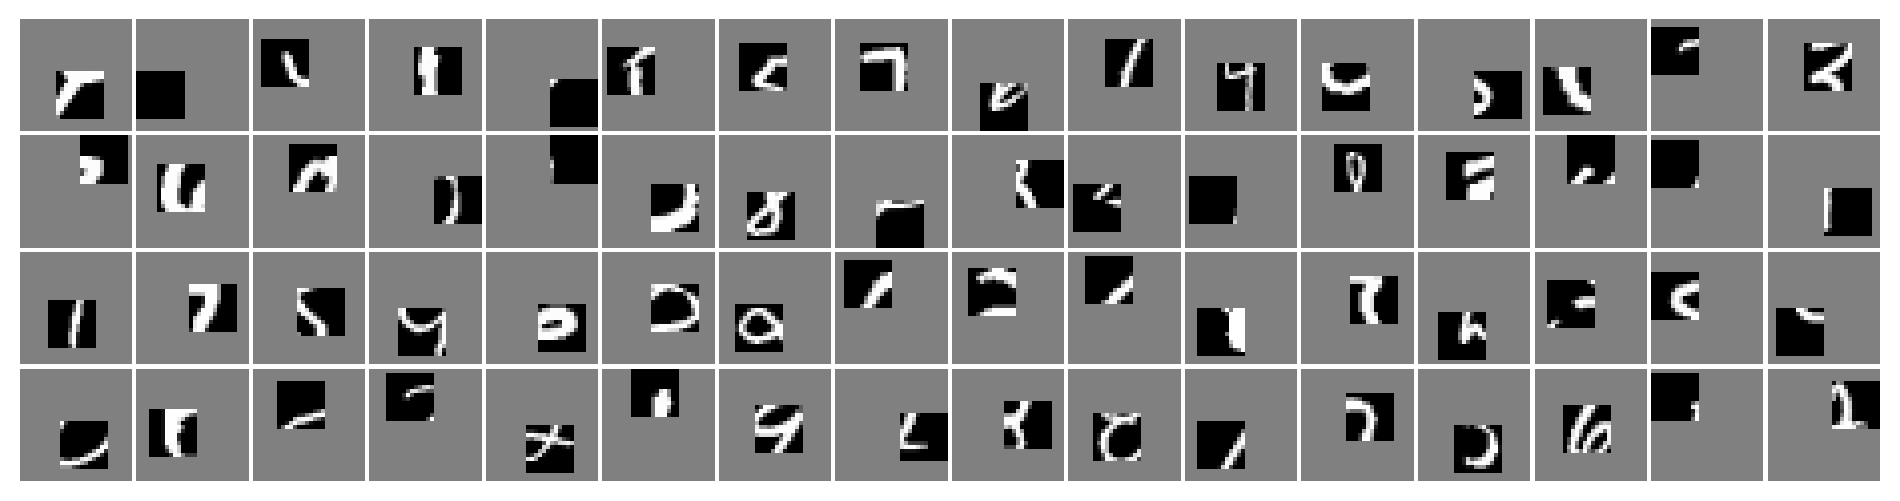

In [9]:
data_samples, mask_samples, _ = next(iter(data_loader))
fig, ax = plt.subplots(figsize=(12, 3))
plot_grid(ax, mask_data(data_samples, mask_samples.float(), .5),
          nrow=4, ncol=16)

# Model

In [10]:
# Must sub-class ConvGenerator to provide transform()
class ConvGenerator(nn.Module):
    def __init__(self, latent_size=128):
        super().__init__()

        self.DIM = 64
        self.latent_size = latent_size

        self.preprocess = nn.Sequential(
            nn.Linear(latent_size, 4 * 4 * 4 * self.DIM),
            nn.ReLU(True),
        )
        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(4 * self.DIM, 2 * self.DIM, 5),
            nn.ReLU(True),
        )
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(2 * self.DIM, self.DIM, 5),
            nn.ReLU(True),
        )
        self.deconv_out = nn.ConvTranspose2d(self.DIM, 1, 8, stride=2)

    def forward(self, input):
        net = self.preprocess(input)
        net = net.view(-1, 4 * self.DIM, 4, 4)
        net = self.block1(net)
        net = net[:, :, :7, :7]
        net = self.block2(net)
        net = self.deconv_out(net)
        return self.transform(net).view(-1, 1, 28, 28)


class ConvDataGenerator(ConvGenerator):
    def __init__(self, latent_size=128):
        super().__init__(latent_size=latent_size)
        self.transform = lambda x: torch.sigmoid(x)


class ConvMaskGenerator(ConvGenerator):
    def __init__(self, latent_size=128, temperature=.66):
        super().__init__(latent_size=latent_size)
        self.transform = lambda x: torch.sigmoid(x / temperature)

In [11]:
class ConvCritic(nn.Module):
    def __init__(self):
        super().__init__()

        self.DIM = 64
        main = nn.Sequential(
            nn.Conv2d(1, self.DIM, 5, stride=2, padding=2),
            nn.ReLU(True),
            nn.Conv2d(self.DIM, 2 * self.DIM, 5, stride=2, padding=2),
            nn.ReLU(True),
            nn.Conv2d(2 * self.DIM, 4 * self.DIM, 5, stride=2, padding=2),
            nn.ReLU(True),
        )
        self.main = main
        self.output = nn.Linear(4 * 4 * 4 * self.DIM, 1)

    def forward(self, input):
        input = input.view(-1, 1, 28, 28)
        net = self.main(input)
        net = net.view(-1, 4 * 4 * 4 * self.DIM)
        net = self.output(net)
        return net.view(-1)

In [12]:
class CriticUpdater:
    def __init__(self, critic, critic_optimizer, batch_size=64, gp_lambda=10):
        self.critic = critic
        self.critic_optimizer = critic_optimizer
        self.gp_lambda = gp_lambda
        # Interpolation coefficient
        self.eps = torch.empty(batch_size, 1, 1, 1, device=device)
        # For computing the gradient penalty
        self.ones = torch.ones(batch_size).to(device)

    def __call__(self, real, fake):
        real = real.detach()
        fake = fake.detach()
        self.critic.zero_grad()
        self.eps.uniform_(0, 1)
        interp = (self.eps * real + (1 - self.eps) * fake).requires_grad_()
        grad_d = grad(self.critic(interp), interp, grad_outputs=self.ones,
                      create_graph=True)[0]
        grad_d = grad_d.view(real.shape[0], -1)
        grad_penalty = ((grad_d.norm(dim=1) - 1)**2).mean() * self.gp_lambda
        w_dist = self.critic(fake).mean() - self.critic(real).mean()
        loss = w_dist + grad_penalty
        loss.backward()
        self.critic_optimizer.step()

In [13]:
nz = 128   # dimensionality of the latent code
n_critic = 5
alpha = .2

data_gen = ConvDataGenerator().to(device)
mask_gen = ConvMaskGenerator().to(device)

data_critic = ConvCritic().to(device)
mask_critic = ConvCritic().to(device)

data_noise = torch.empty(batch_size, nz, device=device)
mask_noise = torch.empty(batch_size, nz, device=device)

lrate = 1e-4
data_gen_optimizer = optim.Adam(
    data_gen.parameters(), lr=lrate, betas=(.5, .9))
mask_gen_optimizer = optim.Adam(
    mask_gen.parameters(), lr=lrate, betas=(.5, .9))

data_critic_optimizer = optim.Adam(
    data_critic.parameters(), lr=lrate, betas=(.5, .9))
mask_critic_optimizer = optim.Adam(
    mask_critic.parameters(), lr=lrate, betas=(.5, .9))

update_data_critic = CriticUpdater(
    data_critic, data_critic_optimizer, batch_size)
update_mask_critic = CriticUpdater(
    mask_critic, mask_critic_optimizer, batch_size)

# Pre train model b4 imputer

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 0


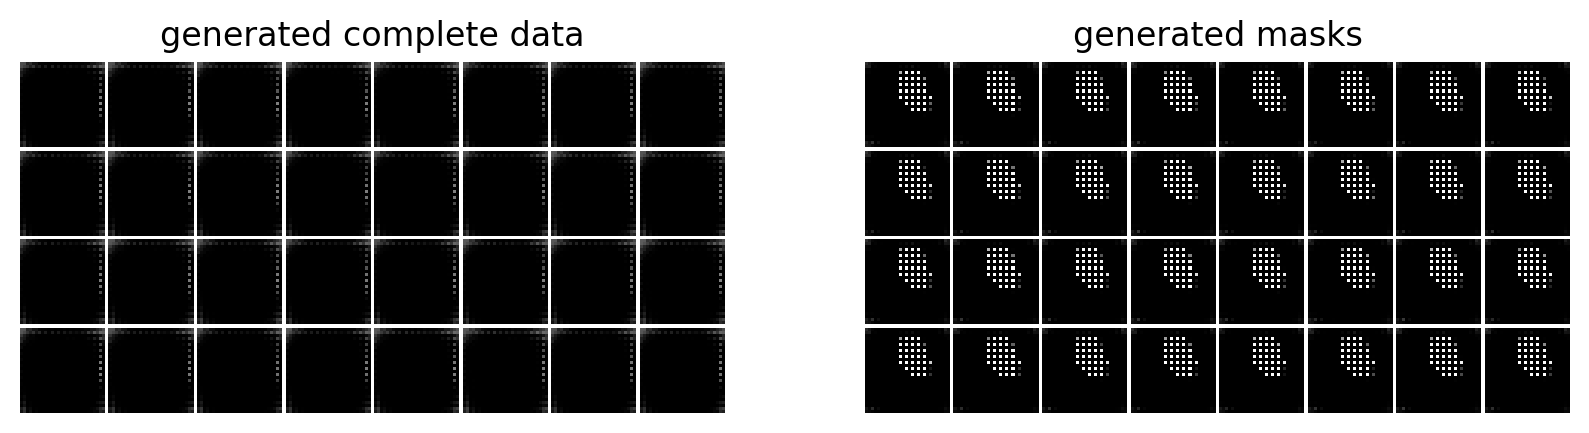

Epoch: 1


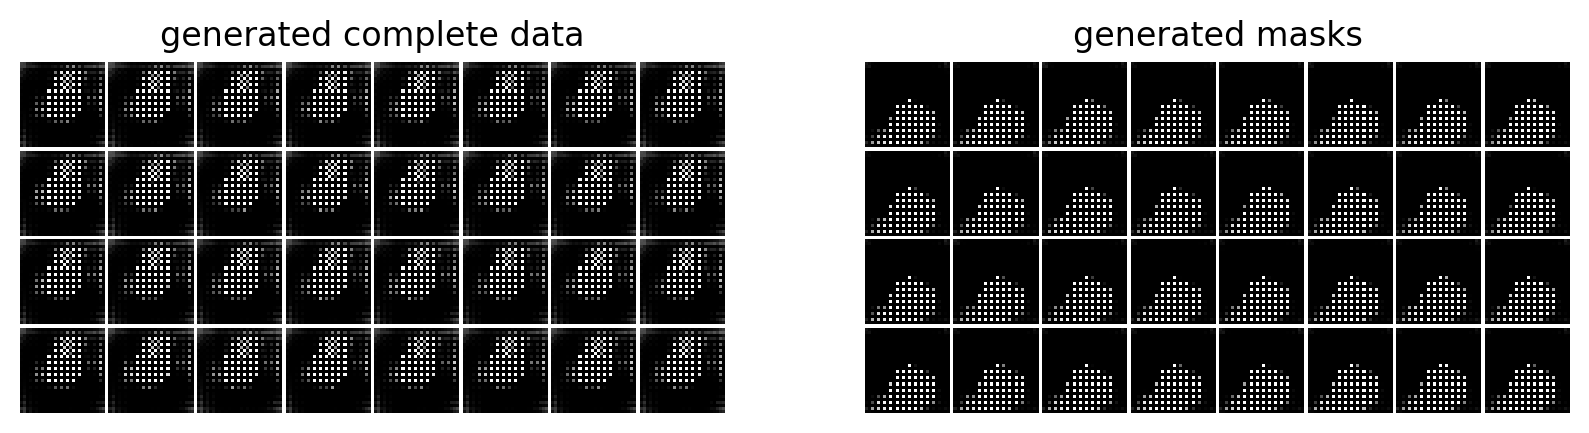

Epoch: 2


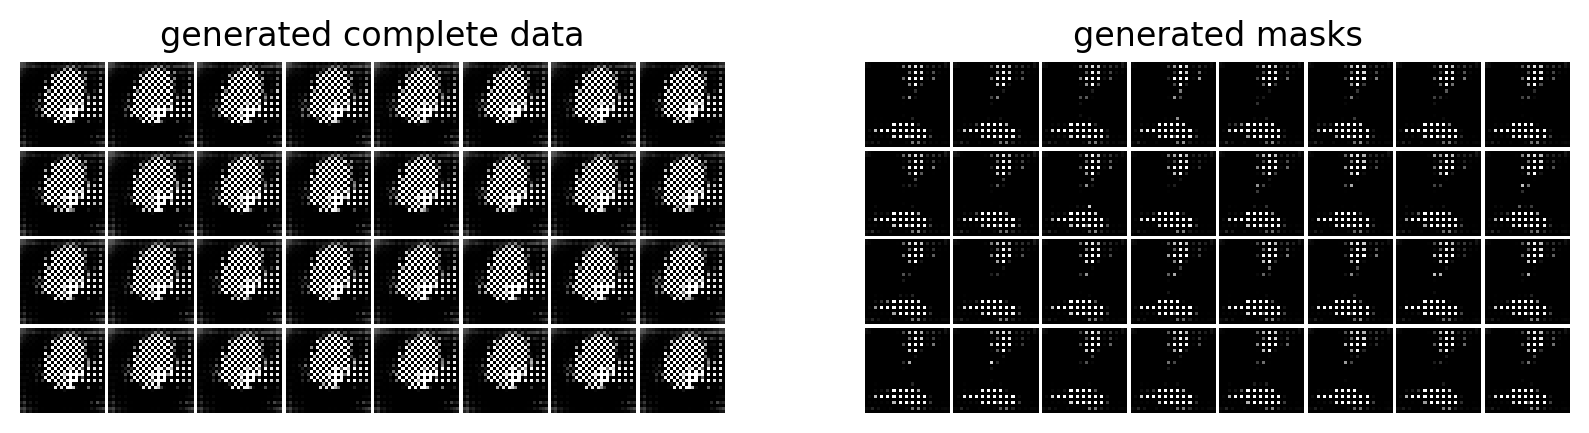

Epoch: 3


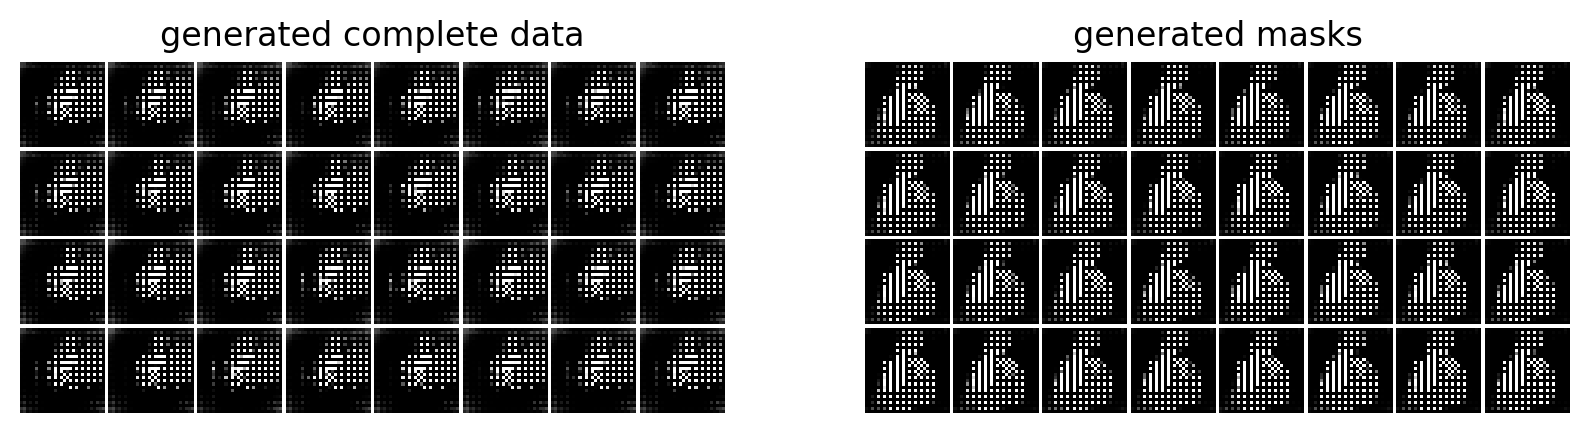

Epoch: 4


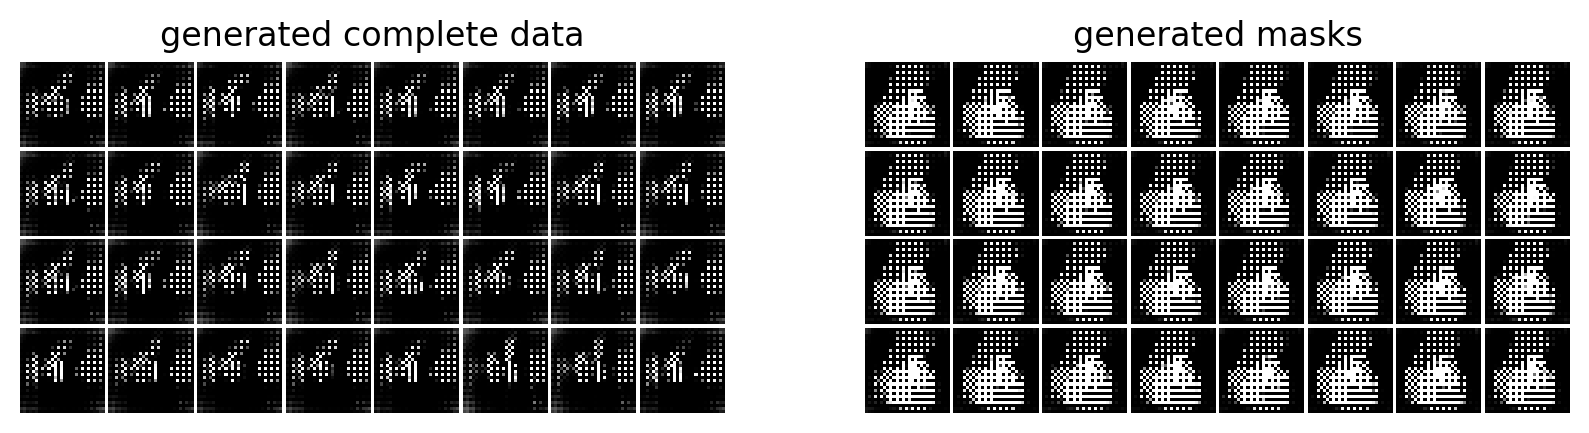

In [14]:
plot_interval = 1
critic_updates = 0

for epoch in range(5):
    for real_data, real_mask, _ in data_loader:

        real_data = real_data.to(device)
        real_mask = real_mask.to(device).float()

        # Update discriminators' parameters
        data_noise.normal_()
        mask_noise.normal_()

        fake_data = data_gen(data_noise)
        fake_mask = mask_gen(mask_noise)

        masked_fake_data = mask_data(fake_data, fake_mask)
        masked_real_data = mask_data(real_data, real_mask)

        update_data_critic(masked_real_data, masked_fake_data)
        update_mask_critic(real_mask, fake_mask)

        critic_updates += 1

        if critic_updates == n_critic:
            critic_updates = 0

            # Update generators' parameters
            for p in data_critic.parameters():
                p.requires_grad_(False)
            for p in mask_critic.parameters():
                p.requires_grad_(False)

            data_gen.zero_grad()
            mask_gen.zero_grad()

            data_noise.normal_()
            mask_noise.normal_()

            fake_data = data_gen(data_noise)
            fake_mask = mask_gen(mask_noise)
            masked_fake_data = mask_data(fake_data, fake_mask)

            data_loss = -data_critic(masked_fake_data).mean()
            data_loss.backward(retain_graph=True)
            data_gen_optimizer.step()

            mask_loss = -mask_critic(fake_mask).mean()
            mask_gen_optimizer.step()

            for p in data_critic.parameters():
                p.requires_grad_(True)
            for p in mask_critic.parameters():
                p.requires_grad_(True)

    if plot_interval > 0 and (epoch + 1) % plot_interval == 0:
        # Although it makes no difference setting eval() in this example,
        # you will need those if you are going to use modules such as
        # batch normalization or dropout in the generators.
        data_gen.eval()
        mask_gen.eval()

        with torch.no_grad():
            print('Epoch:', epoch)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))

            data_noise.normal_()
            data_samples = data_gen(data_noise)
            plot_grid(ax1, data_samples, title='generated complete data')

            mask_noise.normal_()
            mask_samples = mask_gen(mask_noise)
            plot_grid(ax2, mask_samples, title='generated masks')

            plt.show()
            plt.close(fig)

        data_gen.train()
        mask_gen.train()

# run imputer

In [15]:
class Imputer(nn.Module):
    def __init__(self, arch=(512, 512)):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(784, arch[0]),
            nn.ReLU(),
            nn.Linear(arch[0], arch[1]),
            nn.ReLU(),
            nn.Linear(arch[1], arch[0]),
            nn.ReLU(),
            nn.Linear(arch[0], 784),
        )

    def forward(self, data, mask, noise):
        net = data * mask + noise * (1 - mask)
        net = net.view(data.shape[0], -1)
        net = self.fc(net)
        net = torch.sigmoid(net).view(data.shape)
        return data * mask + net * (1 - mask)

In [16]:
imputer = Imputer().to(device)
impu_critic = ConvCritic().to(device)
impu_noise = torch.empty(batch_size, 1, 28, 28, device=device)

imputer_lrate = 2e-4
imputer_optimizer = optim.Adam(
    imputer.parameters(), lr=imputer_lrate, betas=(.5, .9))
impu_critic_optimizer = optim.Adam(
    impu_critic.parameters(), lr=imputer_lrate, betas=(.5, .9))
update_impu_critic = CriticUpdater(
    impu_critic, impu_critic_optimizer, batch_size)

Epoch: 0


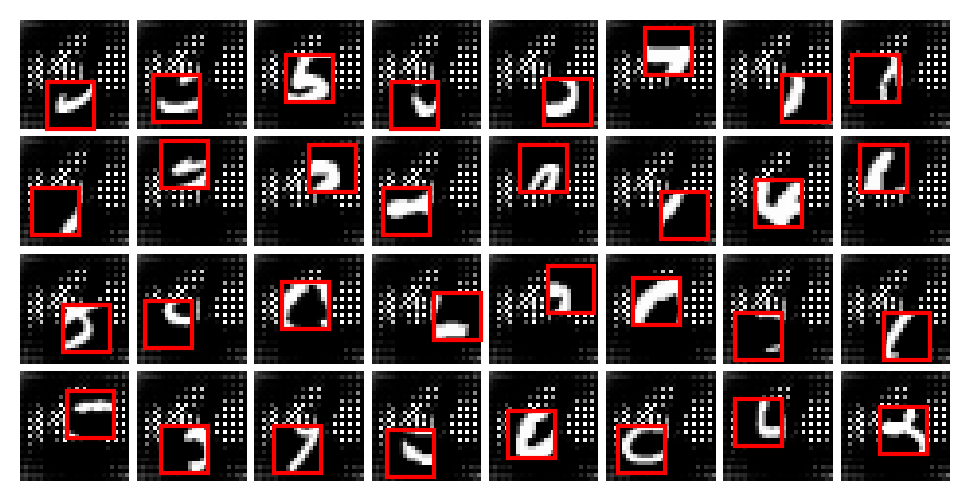

Epoch: 1


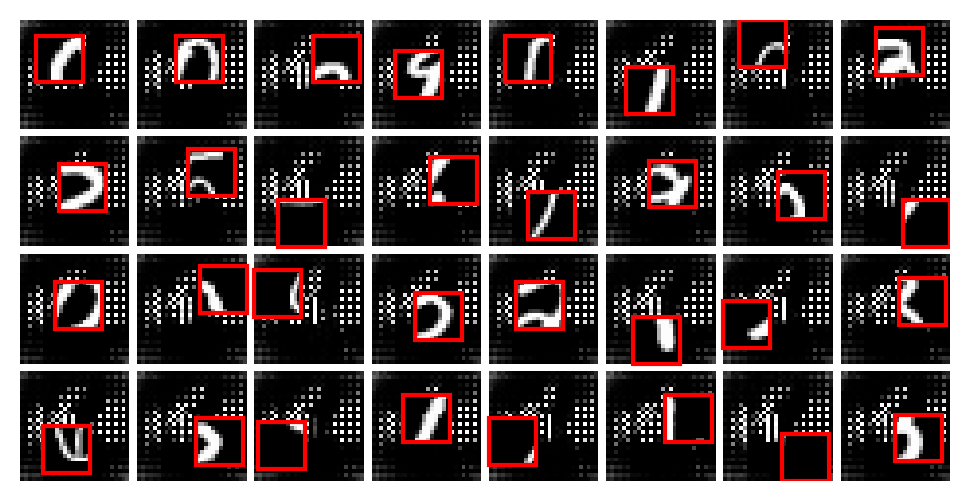

Epoch: 2


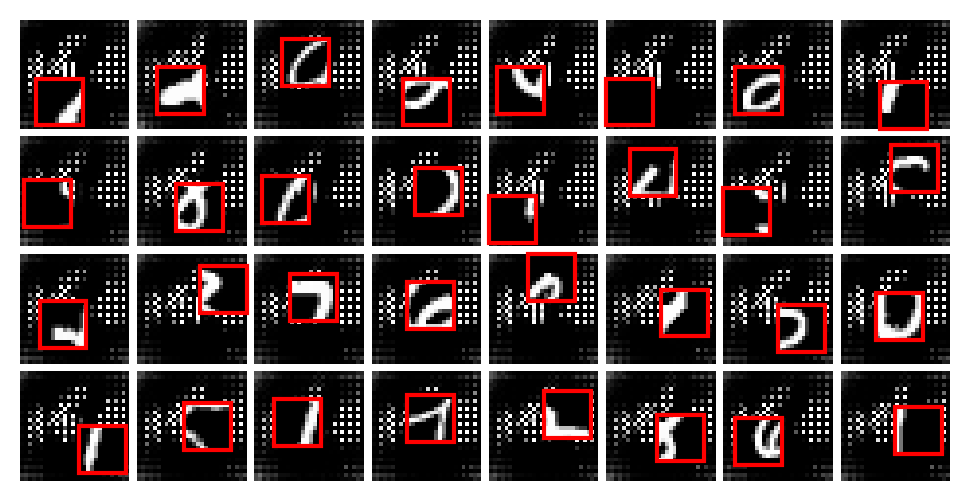

Epoch: 3


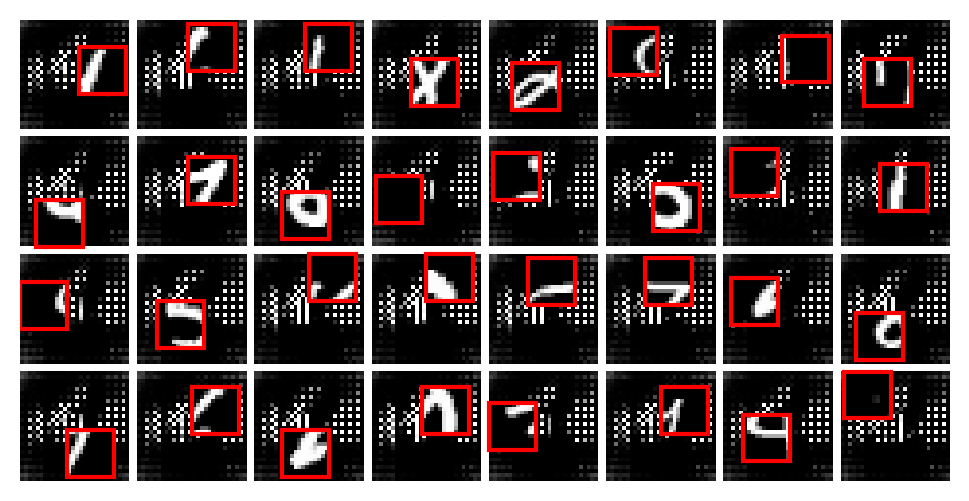

Epoch: 4


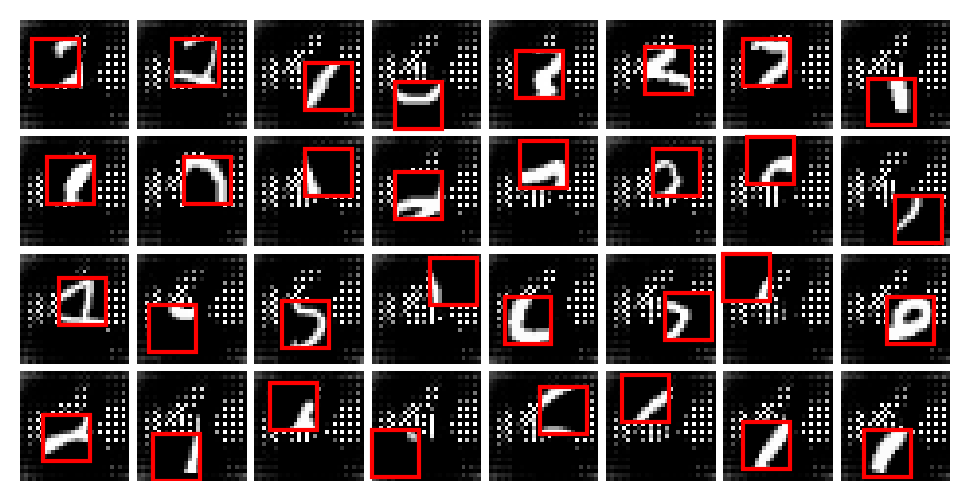

In [17]:
beta = .1
plot_interval = 1
critic_updates = 0

for epoch in range(5):
    for real_data, real_mask, index in data_loader:

        real_data = real_data.to(device)
        real_mask = real_mask.to(device).float()

        masked_real_data = mask_data(real_data, real_mask)

        # Update discriminators' parameters
        data_noise.normal_()
        fake_data = data_gen(data_noise)

        mask_noise.normal_()
        fake_mask = mask_gen(mask_noise)
        masked_fake_data = mask_data(fake_data, fake_mask)

        impu_noise.uniform_()
        imputed_data = imputer(real_data, real_mask, impu_noise)

        update_data_critic(masked_real_data, masked_fake_data)
        update_mask_critic(real_mask, fake_mask)
        update_impu_critic(fake_data, imputed_data)

        critic_updates += 1

        if critic_updates == n_critic:
            critic_updates = 0

            # Update generators' parameters
            for p in data_critic.parameters():
                p.requires_grad_(False)
            for p in mask_critic.parameters():
                p.requires_grad_(False)
            for p in impu_critic.parameters():
                p.requires_grad_(False)

            data_noise.normal_()
            fake_data = data_gen(data_noise)

            mask_noise.normal_()
            fake_mask = mask_gen(mask_noise)
            masked_fake_data = mask_data(fake_data, fake_mask)

            impu_noise.uniform_()
            imputed_data = imputer(real_data, real_mask, impu_noise)

            data_loss = -data_critic(masked_fake_data).mean()
            mask_loss = -mask_critic(fake_mask).mean()
            impu_loss = -impu_critic(imputed_data).mean()

            mask_gen.zero_grad()
            #(mask_loss + data_loss * alpha).backward()
            #(mask_loss + data_loss * alpha).backward(retain_graph=True)
            mask_gen_optimizer.step()

            data_gen.zero_grad()
            #(data_loss + impu_loss * beta).backward()
           # (data_loss + impu_loss * beta).backward(retain_graph=True)
            data_gen_optimizer.step()

            imputer.zero_grad()
            impu_loss.backward()
            imputer_optimizer.step()

            for p in data_critic.parameters():
                p.requires_grad_(True)
            for p in mask_critic.parameters():
                p.requires_grad_(True)
            for p in impu_critic.parameters():
                p.requires_grad_(True)

    if plot_interval > 0 and (epoch + 1) % plot_interval == 0:
        with torch.no_grad():
            imputer.eval()

            # Plot imputation results
            impu_noise.uniform_()
            imputed_data = imputer(real_data, real_mask, impu_noise)
            bbox = [data.mask_loc[idx] for idx in index]
            print('Epoch:', epoch)
            fig, ax = plt.subplots(figsize=(6, 3))
            plot_grid(ax, imputed_data, bbox, gap=2)
            plt.show()
            plt.close(fig)

            imputer.train()